In [1]:
import cached  # joblib based memoization in ./cached.py
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
import seaborn as sns
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

# %matplotlib notebook
%matplotlib inline

uncomment the following cell if editing ./cached.py

# Helper functions

## Network representation

In [2]:
def draw(G, size="compute", layout=None):
    size = dict(G.nodes(data=size)).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

## Gini coefficient

copied from https://stackoverflow.com/a/39513799

In [3]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

# Network Spec

compute 7 [0.03571429 0.07142857 0.10714286 0.14285714 0.17857143 0.21428571
 0.25      ]


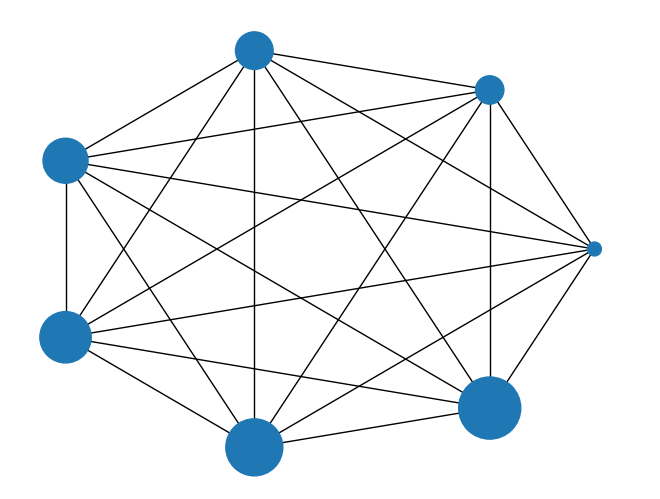

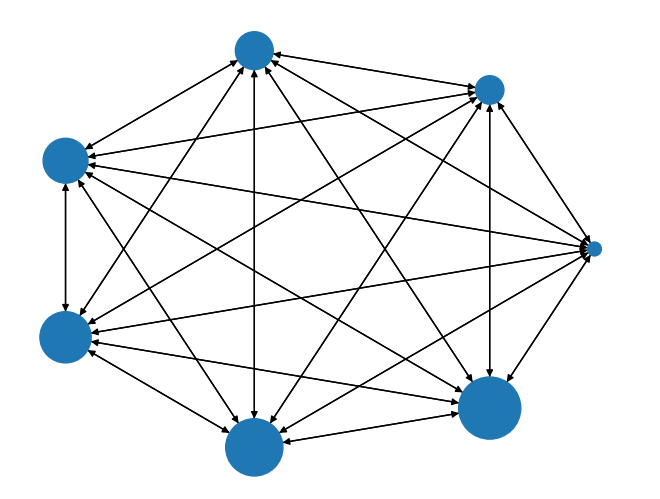

In [4]:
## Mining statistics for the last 7 days before Dec. 12 2022
## from https://www.blockchain.com/explorer/charts/pools
compute = [  # relative hash-rate # blocks mined / pool
    0.24817,  # 271 / Foundry USA
    0.20147,  # 220 / AntPool
    0.15110,  # 165 / F2Pool
    0.13736,  # 150 / Binance Pool
    0.10440,  # 114 / ViaBTC
    0.05311,  # 58  / Braiins Pool
    0.02473,  # 27  / Poolin
    0.01923,  # 21  / BTC.com
    0.01648,  # 18  / Luxor
    0.01465,  # 16  / Mara Pool
    0.00641,  # 7   / Ultimus
    0.00641,  # 7   / SBI Crypto
    0.00366,  # 4   / BTC M4
    0.00275,  # 3   / Titan
    # NaN    # 11  / Unknown
]
assert np.sum(compute) < 1
compute.append(1 - np.sum(compute))

## Simpler compute distributions for quick iteration

compute = list(range(1, 8))
# compute = [ 0.01, 0.99 ]

compute = compute / np.sum(compute)

## Communication

G = nx.complete_graph(len(compute))
G.graph["dissemination"] = "simple"

for i in range(len(compute)):
    G.nodes[i]["compute"] = compute[i]

for a, b in G.edges:
    # G.edges[a, b]["delay"] = f"uniform 0.5 1.5"
    G.edges[a, b]["delay"] = f"constant 6"  # 6 second constant message delay


## Output and checks

print("compute", len(compute), compute)
layout = nx.circular_layout(G)
draw(G, layout=layout)
plt.show()
res = cached.sim(G, activation_delay=600, activations=10000, protocol="nakamoto")
draw(res, size="reward", layout=layout)
plt.show()
# print_(G)

# Measurements

We are going to measure mean inequality and also volatility in rewards.

We know from previous results that the precision of the mean is linear in the number of activations. We should thus use the same number of activations for each reported mean.

For volatility, we fix the time frame (e.g. one day) and run multiple simulations for that length. Then we calculate standard deviation.

Now, activations per day depends on the activation delay. To get the mean estimates right, we run more fixed-time simulations for long activation delays and less simulations for short activation delays. Overall we maintain a constant number of activations across all observed fixed-time simulations.

In [15]:
def subblock_selection(x):
    return "heuristic"

    # altruistic obviously affects equality
    if x.k <= 32:
        return "heuristic"
    else:
        return "altruistic"


families = dict(
    nakamoto=lambda x: "nakamoto",
    bk=lambda x: f"bk-{x.k}-constant",
    bkll=lambda x: f"bkll-{x.k}-constant",
    tailstorm=lambda x: f"tailstorm-{x.k}-{x.scheme}-{subblock_selection(x)}",
    tailstormll=lambda x: f"tailstormll-{x.k}-{x.scheme}-{subblock_selection(x)}",
)


def rows():
    def r(f, k, s, ad, i, n):
        return pd.Series(
            dict(
                family=f,
                k=k,
                scheme=s,
                protocol=f"{f}-{k}-{s}",
                block_interval=ad * k,
                activation_delay=ad,
                seed=i,
                activations=n,
            )
        )

    activations = 200_000  # per protocol, split into slots of one day

    # nakamoto
    for bi in [75 / 8, 75 / 4, 75 / 2, 75, 150, 300, 600]:
        ad = bi
        n = int(60 * 60 * 24 / ad)  # time per simulation should be roughly one day
        for i in range(int(activations / n)):
            yield r("nakamoto", 1, "constant", ad, i, n)

    # bk and tailstorm
    for k in [2, 4, 8, 16, 32, 64]:
        bi = 600
        ad = bi / k
        n = int(60 * 60 * 24 / ad)  # time per simulation should be roughly one day
        for i in range(int(activations / n)):
            yield r("bk", k, "constant", ad, i, n)
            yield r("tailstorm", k, "constant", ad, i, n)
            yield r("tailstorm", k, "discount", ad, i, n)


def measure(x):
    res = cached.sim(
        G,
        activation_delay=x.activation_delay,
        activations=x.activations,
        protocol=families[x.family](x),
        seed=x.seed,
    )

    def read(G, field):
        return np.array([G.nodes[i][field] for i in range(len(G.nodes))])

    reward = read(res, "reward")
    activations = read(res, "activations")
    assert sum(activations) == x.activations
    compute = read(res, "compute")
    compute = compute / np.sum(compute)
    relrew = reward / np.sum(reward)
    relrewn = relrew / compute
    efficiency0 = reward / compute
    with np.errstate(divide="ignore", invalid="ignore"):
        efficiency1 = np.where(activations > 0, reward / activations, 0.0)
    weakest = np.argmin(compute)
    strongest = np.argmax(compute)
    return pd.Series(
        dict(
            machine_duration=res.graph["machine_duration"],
            chain_time=res.graph["chain_time"],
            progress=res.graph["progress"],
            height=res.graph["progress"] / x.k,
            reward=np.sum(reward),
            revenue_loss=1 - (np.sum(reward) / np.sum(activations)),
            weakest_reward=reward[weakest],
            weakest_relrew=relrew[weakest],
            weakest_relrewn=relrewn[weakest],
            weakest_efficiency0=efficiency0[weakest],
            weakest_efficiency1=efficiency1[weakest],
            strongest_reward=reward[strongest],
            strongest_relrew=relrew[strongest],
            strongest_relrewn=relrewn[strongest],
            strongest_efficiency0=efficiency0[strongest],
            strongest_efficiency1=efficiency1[strongest],
            gini_reward=gini(reward),
            gini_relrew=gini(relrew),
            gini_relrewn=gini(relrewn),
            gini_efficiency0=gini(efficiency0),
            gini_efficiency1=gini(efficiency1),
        )
    )


def parallel_measure(df, fun=measure, n_jobs=-1):
    df = df.sample(frac=1).reset_index(drop=True)

    res = Parallel(n_jobs=n_jobs)(
        delayed(measure)(row) for idx, row in tqdm(df.iterrows(), total=len(df))
    )
    return pd.concat([df, pd.DataFrame(res)], axis=1)


df = pd.DataFrame(rows())
display(df)
df = parallel_measure(df)

,family,k,scheme,protocol,block_interval,activation_delay,seed,activations
0,nakamoto,1,constant,nakamoto-1-constant,9.375,9.375,0,9216
1,nakamoto,1,constant,nakamoto-1-constant,9.375,9.375,1,9216
2,nakamoto,1,constant,nakamoto-1-constant,9.375,9.375,2,9216
3,nakamoto,1,constant,nakamoto-1-constant,9.375,9.375,3,9216
4,nakamoto,1,constant,nakamoto-1-constant,9.375,9.375,4,9216
...,...,...,...,...,...,...,...,...
6839,tailstorm,64,constant,tailstorm-64-constant,600.000,9.375,19,9216
6840,tailstorm,64,discount,tailstorm-64-discount,600.000,9.375,19,9216
6841,bk,64,constant,bk-64-constant,600.000,9.375,20,9216
6842,tailstorm,64,constant,tailstorm-64-constant,600.000,9.375,20,9216


  0%|          | 0/6844 [00:00<?, ?it/s]

# Analysis

## Table

In [16]:
display(
    df
    # .assign(family = pd.Categorical(df.family, categories=['nakamoto', 'bk', 'tailstorm']))
    .groupby(
        ["family", "k", "scheme", "block_interval", "activation_delay", "activations"]
    )
    .agg(
        chain_time_mean=("chain_time", np.mean),
        progress_mean=("progress", np.mean),
        height_mean=("height", np.mean),
        reward_mean=("reward", np.mean),
        weakest_rr_mean=("weakest_relrew", np.mean),
        weakest_rr_std=("weakest_relrew", np.std),
        strongest_rr_mean=("strongest_relrew", np.mean),
        strongest_rr_std=("strongest_relrew", np.std),
        rr_gini_mean=("gini_relrewn", np.mean),
        rr_gini_std=("gini_relrewn", np.std),
        nobs=("weakest_relrewn", len),
    )
    .query("nobs > 0")
    .sort_values(["k", "family", "scheme", "block_interval"])
    .reset_index()
    .assign(acc_activations=lambda d: d.activations * d.nobs)
)
display(compute)

,family,k,scheme,block_interval,activation_delay,activations,chain_time_mean,progress_mean,height_mean,reward_mean,weakest_rr_mean,weakest_rr_std,strongest_rr_mean,strongest_rr_std,rr_gini_mean,rr_gini_std,nobs,acc_activations
0,nakamoto,1,constant,9.375,9.375,9216,86563.936003,6273.619048,6273.619048,6273.619048,0.028683,0.002440,0.273383,0.008479,0.058712,0.010867,21,193536
1,nakamoto,1,constant,18.750,18.750,4608,86627.539561,3693.093023,3693.093023,3693.093023,0.032853,0.002705,0.262375,0.008191,0.037812,0.009853,43,198144
2,nakamoto,1,constant,37.500,37.500,2304,86522.122649,2043.558140,2043.558140,2043.558140,0.034982,0.003737,0.256389,0.010622,0.035438,0.009028,86,198144
3,nakamoto,1,constant,75.000,75.000,1152,86495.703617,1081.283237,1081.283237,1081.283237,0.034924,0.005270,0.254521,0.014350,0.046071,0.013338,173,199296
4,nakamoto,1,constant,150.000,150.000,576,86402.967735,557.435159,557.435159,557.435159,0.035407,0.008249,0.252891,0.018652,0.065482,0.021136,347,199872
5,nakamoto,1,constant,300.000,300.000,288,86454.311823,283.246398,283.246398,283.246398,0.035699,0.011221,0.250604,0.026211,0.090228,0.030106,694,199872
6,nakamoto,1,constant,600.000,600.000,144,86463.097162,142.819885,142.819885,142.819885,0.035611,0.015866,0.250152,0.036403,0.127905,0.041866,1388,199872
7,bk,2,constant,600.000,300.000,288,86295.750595,283.968300,141.984150,283.968300,0.035725,0.011374,0.249965,0.025894,0.090199,0.030282,694,199872
8,tailstorm,2,constant,600.000,300.000,288,86290.681092,285.106628,142.553314,285.106628,0.035764,0.011256,0.250240,0.026045,0.089802,0.030440,694,199872
9,tailstorm,2,discount,600.000,300.000,288,86290.681092,285.106628,142.553314,282.724784,0.035730,0.011291,0.250379,0.026171,0.090103,0.030226,694,199872


array([0.03571429, 0.07142857, 0.10714286, 0.14285714, 0.17857143,
       0.21428571, 0.25      ])

# Nakamoto as benchmark

Fast and slow. Block interval 9.375s on the left to 600s on the right.

## Relative reward of weakest miner

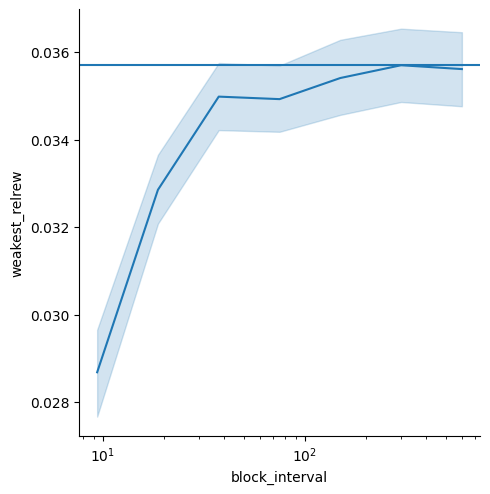

In [25]:
ax = sns.relplot(
    kind="line",
    data=df.query("family=='nakamoto'"),
    y="weakest_relrew",
    x="block_interval",
)
ax.set(xscale="log")
plt.axhline(np.min(compute))

## Relative reward of strongest miner

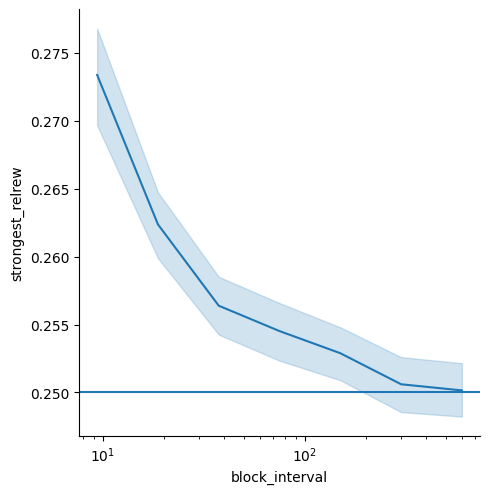

In [26]:
ax = sns.relplot(
    kind="line",
    data=df.query("family=='nakamoto'"),
    y="strongest_relrew",
    x="block_interval",
)
ax.set(xscale="log")
plt.axhline(np.max(compute))

## Gini coefficient of relative reward across all miners

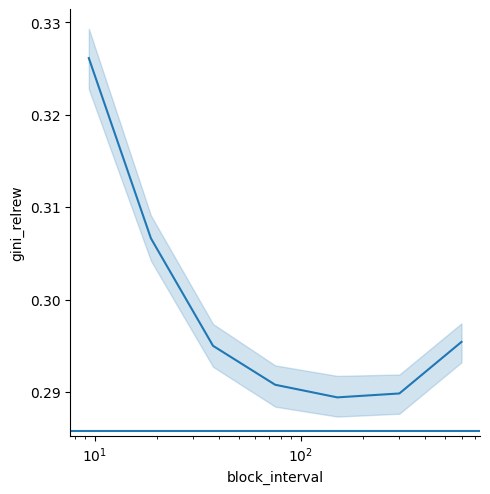

In [28]:
ax = sns.relplot(
    kind="line",
    data=df.query("family=='nakamoto'"),
    y="gini_relrew",
    x="block_interval",
)
ax.set(xscale="log")
plt.axhline(gini(compute))

# New protocols

For different k's. From k = 2 on the left to k = 64 on the right.

## Block interval 600s

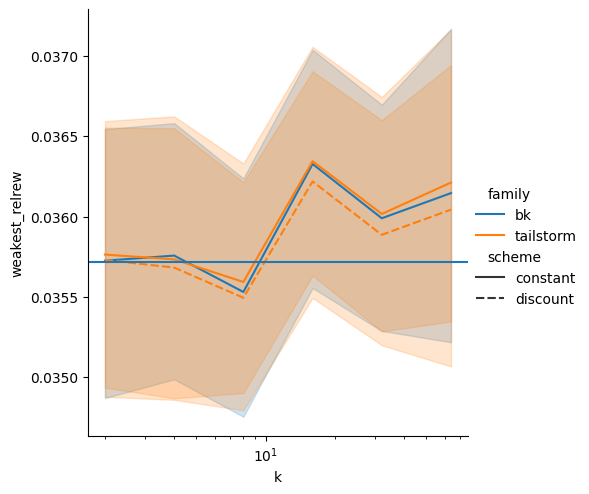

In [31]:
ax = sns.relplot(
    kind="line",
    data=df.query("family!='nakamoto'"),
    hue="family",
    style="scheme",
    y="weakest_relrew",
    x="k",
)
ax.set(xscale="log")
plt.axhline(np.min(compute))

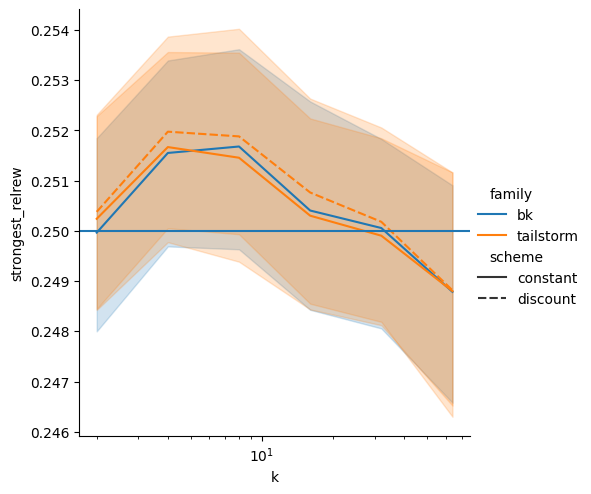

In [32]:
ax = sns.relplot(
    kind="line",
    data=df.query("family!='nakamoto'"),
    hue="family",
    style="scheme",
    y="strongest_relrew",
    x="k",
)
ax.set(xscale="log")
plt.axhline(np.max(compute))

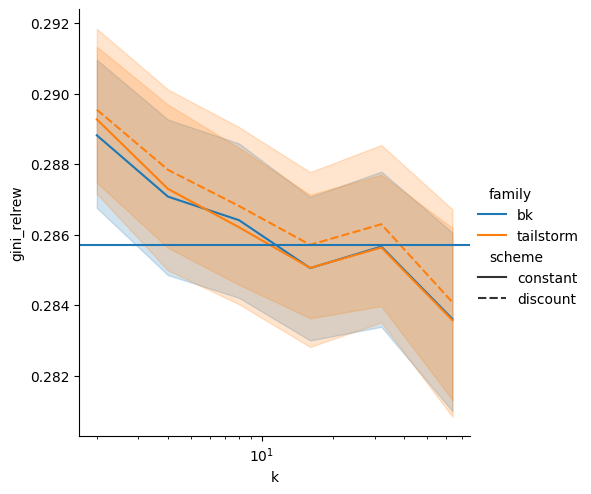

In [33]:
ax = sns.relplot(
    kind="line",
    data=df.query("family!='nakamoto'"),
    hue="family",
    style="scheme",
    y="gini_relrew",
    x="k",
)
ax.set(xscale="log")
plt.axhline(gini(compute))

# ToDo
- plot some curves for gini and normalized reward of weakest miner
- tex the table, maybe reduce columns